# Word Embeddings

Word embeddings refers to representing natural language words as vectors (called "embeddings"). Specifically, we are interested in automatically learning a compact (also known as "dense") embedding which carries the semantic meaning of the word.

A simple motivating principle is that words that appear in similar contexts have similar meanings, and thus should have similar embeddings.

With this idea, we can construct an optimization problem where we would like to make the word vectors that appear in similar contexts more "similar". We use cosine-similarity to assign a numeric value to how similar vectors are, and we will say that vectors that appear within some fixed distance from each other are in similar contexts. Our optimization problem is

$$ \mathrm{max}_{v, v'}\ \frac{1}{T} \sum_{t=1}^T \sum_{-c \le j \le c, j \neq 0} \log \frac{\mathrm{exp}({v'_{w_{t+j}}}^T v_{w_t})}{\sum_{w=1}^W \mathrm{exp}({v'_w}^T v_{w_t})} $$

where $v$ and $v'$ are referred to as the input and output vector representations, $c$ is our context size, $T$ is our corpus size, and $W$ is our vocab size. We can approximately solve this optimization problem greedily, with stochastic gradient ascent (this is known as "training"). When we are done training, we will arbitrarily pick one of the embeddings to keep. This model is known as Skip-gram, introduced by Mikolov, et. al. in "Distributed Representations of Words and Phrases and their Compositionality". This is just one such way to create word embeddings.

## Overview

We will begin by processing a small dataset and then using it to train our implmentation of Skip-gram. As we only have limited resources, the idea here is to implement the algorithm and see signs of life in the results. 

Later, we will download the word embeddings from the original paper and explore them.

## A small experiment

The WikiText-2 dataset is a dataset scraped from Wikipedia containing roughly 2 million tokens. Let's download the dataset.

In [1]:
# Code lifted from "Load and batch data" of this official PyTorch tutorial:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
import re
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.manifold import TSNE
import torch
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

url = 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip'
test_filepath, valid_filepath, train_filepath = extract_archive(download_from_url(url))

Let's read the first few lines of the training set.

In [2]:
with open(train_filepath) as f:
    data = f.read()
print(data[0:1000])

 
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . 
 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcomers . Char

It's the Wikipedia page for a PlayStation Portable game called "Valkyria Chronicles III". Notice how we already have Japanese characters on the third line.

To process this for our experiment, we will lowercase all of the words and keep only the words formed from alphabetic characters of length >1.

In [3]:
# Lowercase all of the words
data = data.lower()
# A list of all alphabetic only words which are of length at least 2, stray characters appear in the dataset
data = re.findall("[a-z][a-z]+", data)
print("There were " + str(len(data)) + " words extracted.")
# Get counts of each word
from collections import Counter
counts = Counter(data)
print("There are " + str(len(counts)) + " unique words.")

There were 1630299 words extracted.
There are 27202 unique words.


Let's look more at the vocab

The 10 most common words are:


[('the', 130768),
 ('of', 57030),
 ('unk', 54625),
 ('and', 50735),
 ('in', 45015),
 ('to', 39521),
 ('was', 21008),
 ('on', 15151),
 ('as', 15058),
 ('that', 14351)]

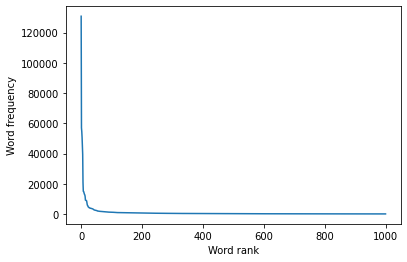

In [4]:
sorted_counts_values = sorted(counts.values(), reverse=True)
plt.plot(sorted_counts_values[0:1000])
plt.xlabel("Word rank")
plt.ylabel("Word frequency")
print("The 10 most common words are:")
counts.most_common(10)

The third most common word in the processed dataset is "unk" for the unknown word token, which is part of the dataset. The distribution is very long tailed. Of the $27202$ unique words extracted, we will only keep the $500$ most common words for our vocabulary in this experiment.

The "word2index" dictionary will map each word in the vocabulary to a unique index.

In [5]:
sorted_counts_keys = sorted(counts, key=counts.get, reverse=True)
vocab = set(sorted_counts_keys[0:500])
word2index = dict(zip(vocab, range(len(vocab))))

Now we will produce $2$ tensors, "word_x" and "word_y" which contain the indices of word pairs that appear in the same context. We will throw away words which don't appear in the vocabulary, and throw away a word with probability $1 - \sqrt{\frac{t}{f(w_i)}}$, where $t = 10^{-5}$ is a threshold and $f(w_i)$ is the word frequency. This was suggested by the original paper to "counter the imbalance in the rare and frequent words".

Representing the data for training in this way, and the training implementation further below were partially inspired by [this Kaggle post](https://www.kaggle.com/karthur10/skip-gram-implementation-with-pytorch-step-by-step).

In [6]:
context_size = 5
threshold = 1e-5

data_x = []
data_y = []
ind = context_size
offsets = list(range(-context_size,0)) + list(range(1,context_size+1))

data_vocab = []
for x in data:
    if x in vocab:
        data_vocab.append(x)
counts_vocab = Counter(data_vocab)

for ind in range(context_size, len(data_vocab)-context_size):
    x = data_vocab[ind]
    if np.random.rand() < (1 - np.sqrt(threshold*len(data_vocab)/counts_vocab[x])):
        continue
    
    for o in offsets:
        y = data_vocab[ind+o]
        data_x.append(word2index[x])
        data_y.append(word2index[y])
    
word_x = torch.tensor(data_x).long().to(device)
word_y = torch.tensor(data_y).long().to(device)

In [72]:
print("word_x and word_y are of length " + str(len(data_x)) + ".")

word_x and word_y are of length 519460.


Finally, we have the implementation of training itself. 

Each of the vector representations will be the columns of two matrices, $V_{in} = [v_{w_1}, \ldots, v_{w_W}]$, $V_{out} = [v'_{w_1}, \ldots, v'_{w_W}]$. We will select a $w_{t}$ and $w_{t+j}$ from "word_x" and "word_y" to approximate the objective with this single sample. 

Creating a one hot representation of the index for $w_{t}$ and multiplying it by $V_{in}$ will result in $v_{w_t}$ getting extracted from the matrix. We will then multiply $V_{out}^T$ by this representation to produce a vector of dot products between $v_{w_t}$ and all $v'_i$. 

Finally, from the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), one can see that "CrossEntropyLoss(x, class)" produces $$-\log\left(\frac{\mathrm{exp(x[class])}}{\sum_j \mathrm{exp(x[j])}}\right)$$ which is negative of the objective we desire. Thus, gradient descent on this objective will result in gradient ascent on the original objective.

Epoch: 0
Iteration 10000 : Loss 6.951177
Iteration 20000 : Loss 18.347073
Iteration 30000 : Loss 10.970131
Iteration 40000 : Loss 11.060314
Iteration 50000 : Loss 5.854184
Iteration 60000 : Loss 14.391951
Iteration 70000 : Loss 2.8142357
Iteration 80000 : Loss 4.2534013
Iteration 90000 : Loss 8.285237
Iteration 100000 : Loss 11.397678
Iteration 110000 : Loss 3.0934143
Iteration 120000 : Loss 4.053805
Iteration 130000 : Loss 9.257697
Iteration 140000 : Loss 9.8678
Iteration 150000 : Loss 11.226415
Iteration 160000 : Loss 1.8305166
Iteration 170000 : Loss 6.220655
Iteration 180000 : Loss 4.3047237
Iteration 190000 : Loss 2.022412
Iteration 200000 : Loss 3.5002072
Iteration 210000 : Loss 1.8768691
Iteration 220000 : Loss 2.7388666
Iteration 230000 : Loss 9.2270565
Iteration 240000 : Loss 7.275404
Iteration 250000 : Loss 2.414523
Iteration 260000 : Loss 4.009081
Iteration 270000 : Loss 3.4166236
Iteration 280000 : Loss 3.247592
Iteration 290000 : Loss 4.5114393
Iteration 300000 : Loss 3.97

Iteration 2400000 : Loss 5.6986384
Iteration 2410000 : Loss 2.8948545
Iteration 2420000 : Loss 3.5995712
Iteration 2430000 : Loss 8.019502
Iteration 2440000 : Loss 6.954036
Iteration 2450000 : Loss 7.882235
Iteration 2460000 : Loss 6.8494554
Iteration 2470000 : Loss 5.628128
Iteration 2480000 : Loss 6.61337
Iteration 2490000 : Loss 8.270544
Iteration 2500000 : Loss 2.1456413
Iteration 2510000 : Loss 2.7692482
Iteration 2520000 : Loss 6.341278
Iteration 2530000 : Loss 4.3365145
Iteration 2540000 : Loss 5.045677
Iteration 2550000 : Loss 1.8240587
Iteration 2560000 : Loss 4.5015635
Iteration 2570000 : Loss 5.5261354
Iteration 2580000 : Loss 5.954975
Iteration 2590000 : Loss 2.2519245
Epoch: 5
Iteration 2600000 : Loss 4.4403086
Iteration 2610000 : Loss 5.3638735
Iteration 2620000 : Loss 6.63315
Iteration 2630000 : Loss 5.892632
Iteration 2640000 : Loss 2.0237277
Iteration 2650000 : Loss 5.5215454
Iteration 2660000 : Loss 2.7222724
Iteration 2670000 : Loss 7.054063
Iteration 2680000 : Loss 

Iteration 4760000 : Loss 2.7385173
Iteration 4770000 : Loss 4.273532
Iteration 4780000 : Loss 2.7695742
Iteration 4790000 : Loss 5.7958775
Iteration 4800000 : Loss 2.2771685
Iteration 4810000 : Loss 5.211438
Iteration 4820000 : Loss 5.604832
Iteration 4830000 : Loss 3.083559
Iteration 4840000 : Loss 1.8444268
Iteration 4850000 : Loss 2.7736807
Iteration 4860000 : Loss 4.017213
Iteration 4870000 : Loss 5.8744516
Iteration 4880000 : Loss 2.8773034
Iteration 4890000 : Loss 3.5462294
Iteration 4900000 : Loss 6.247588
Iteration 4910000 : Loss 2.8070676
Iteration 4920000 : Loss 5.6086817
Iteration 4930000 : Loss 4.35781
Iteration 4940000 : Loss 4.46272
Iteration 4950000 : Loss 7.483116
Iteration 4960000 : Loss 7.123685
Iteration 4970000 : Loss 5.9120865
Iteration 4980000 : Loss 3.0264924
Iteration 4990000 : Loss 2.5834517
Iteration 5000000 : Loss 6.1624403
Iteration 5010000 : Loss 5.890824
Iteration 5020000 : Loss 6.408117
Iteration 5030000 : Loss 1.6902672
Iteration 5040000 : Loss 6.3831325

Text(0, 0.5, 'Loss')

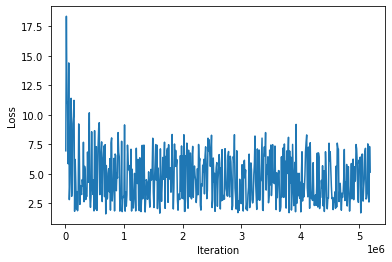

In [8]:
%%time
# Parameters
epochs = 10
vector_dim = 25
lr = 5e-3

V_in = torch.randn(vector_dim, len(vocab), requires_grad=True, device=device)
V_out = torch.randn(vector_dim, len(vocab), requires_grad=True, device=device)
optimizer = torch.optim.SGD([V_in, V_out], lr=lr)
loss_f = torch.nn.CrossEntropyLoss()

losses = []
iters = []
log_freq = 10000
log_count = 0

for epoch in range(epochs):
    print("Epoch: " + str(epoch))
    for x, y in zip(word_x, word_y):
        x_onehot = torch.nn.functional.one_hot(x, num_classes=len(vocab)).float().view(-1,1)
        z = torch.matmul(V_in, x_onehot)
        logits = torch.matmul(V_out.T, z)
        
        loss = loss_f(logits.view(1,-1), y.view(1,))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log
        log_count += 1
        if (log_count % log_freq == 0):
            with torch.no_grad():
                loss_np = loss.cpu().numpy()
                print('Iteration ' + str(log_count) + ' : Loss ' + str(loss_np))
                losses.append(loss_np)
                iters.append(log_count)

plt.plot(iters, losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")

To visualize what we've learned, we can embed the vectors in a 2D space with t-SNE. Some words which I think have an interesting embedding are in red.

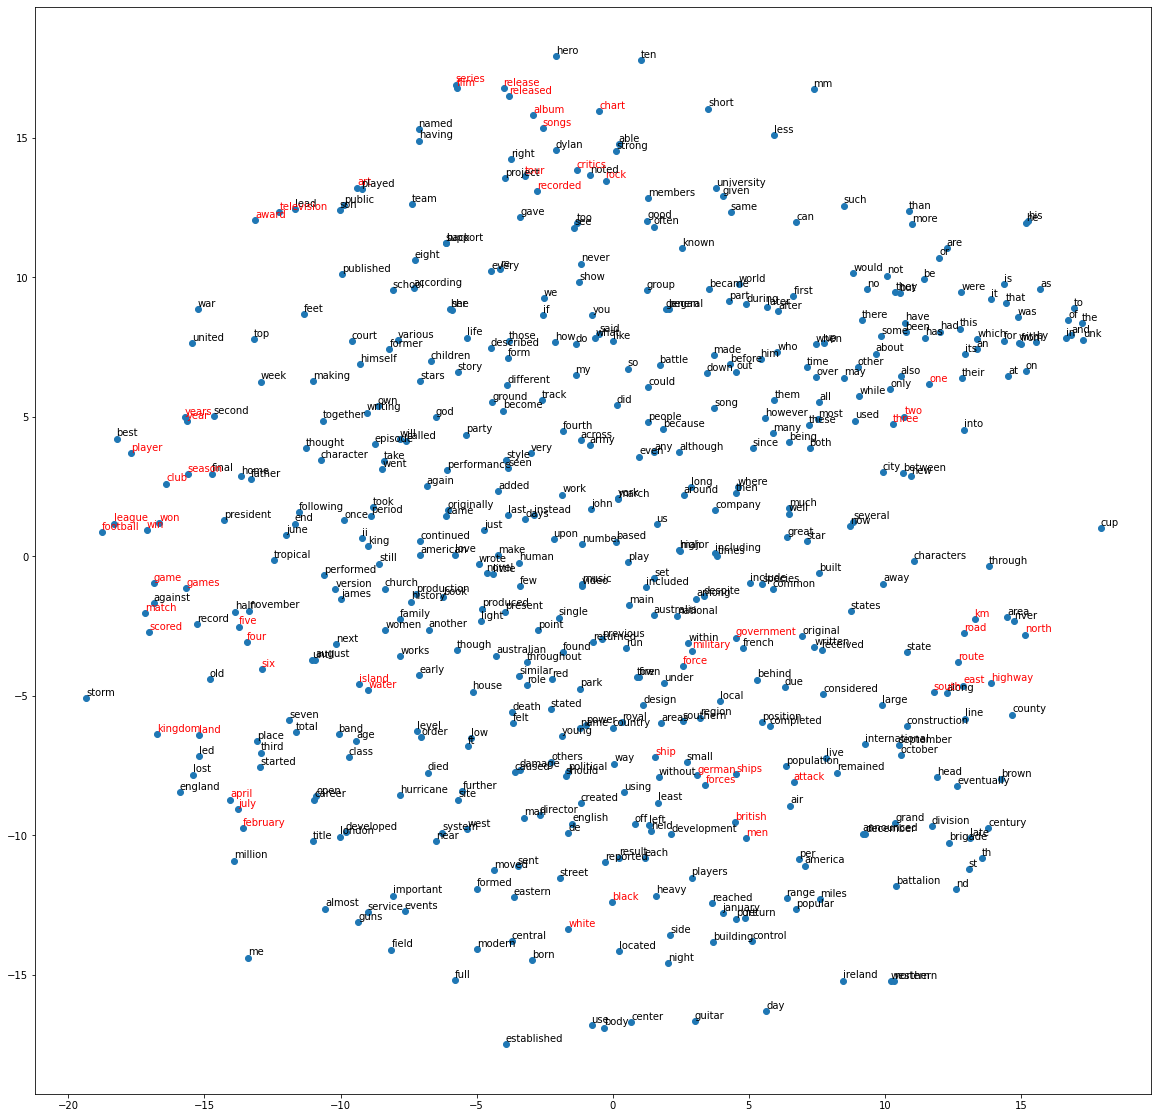

In [37]:
V_in_np = V_in.cpu().detach().numpy()
V_out_np = V_out.cpu().detach().numpy()

tsne = TSNE(n_components=2, random_state=1)
dec = tsne.fit_transform(V_out_np.T)
fig, ax = plt.subplots(figsize=[20,20])
ax.scatter(dec[:,0], dec[:,1])
interesting_words = set(["april","july","february","kingdom","land","album","songs","black","white",\
                         "year","years","football","league","military","force","government","match","scored",\
                         "game","games","island","water","one","two","three","highway","route","road","km",\
                         "german","british","ship","ships","forces","men","attack","east","south","north","win","won",\
                         "four","five","six", "player", "club", "season", "series", "film", "art", "television",\
                         "award", "release", "released", "critics", "recorded", "rock", "tour", "chart"])
for x, i in word2index.items():
    color = "k"
    if x in interesting_words:
        color = "r"
    ax.annotate(x, (dec[i,0], dec[i,1]+0.1), color=color)

From the t-SNE embedding, one can see we have actually learned quite a bit from this small dataset with a limited vocabulary. There are nice groups emerging, like "one two three", "year years", "april july february". There is also a group on the left about sports "football league won win player club season match game games scored", road networks on the right "road route highway north south east km", and music on the top "album songs tour recorded  rock critics". The group "german british forces ship ships men attack" appears to be a bias in the data; the phrase "World War I" appears 211 times and "World War II" appears 133 times in the training data (found with grep). In the top right, all of the words which are not nouns, verbs, adjectives, or adverbs are grouped together, like "the to of the and in at on into an which this had", etc.

From looking at the plot of the loss there appears to be a saturation in performance. This suggests that either the model capacity or the small dataset are the bottleneck in performance. Given that the vocabulary size is very small, it seems more likely that the bottleneck is the small dataset.

## Pretrained embeddings
Now we will investigate the use of a pretrained embedding. We will download the embeddings from the original Skip-gram paper. The training corpus for the original paper is over a thousand times bigger than the one we used for our experiment above.

In [66]:
from gensim import models

# The trained vectors from the original paper
GoogleNewsPath = download_from_url('https://drive.google.com/uc?export=download&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM')

pretrained_model = models.KeyedVectors.load_word2vec_format(GoogleNewsPath, binary=True)

With the pretrained embeddings, we can extract all of the vectors for the vocabulary we used in our small experiment. We can then make the same 2D t-SNE embedding.

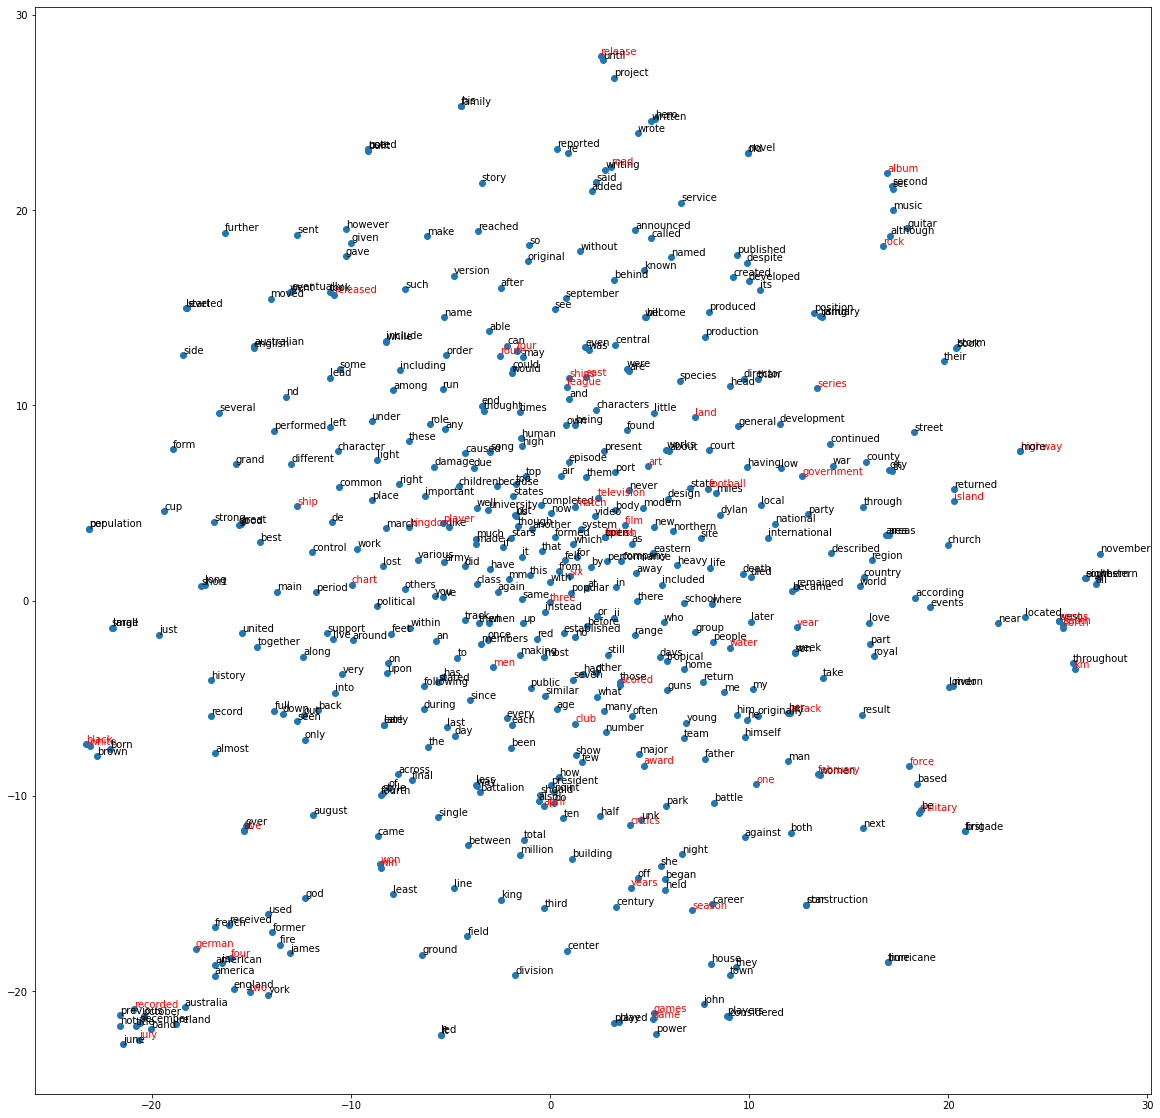

In [67]:
pretrained = np.zeros((300, len(vocab)))
t = 0
for x in vocab:
    if x not in pretrained_model:
        continue
    pretrained[:, t] = np.array(pretrained_model[x])
    t = t + 1

tsne = TSNE(n_components=2, random_state=1)
dec = tsne.fit_transform(pretrained.T)
fig, ax = plt.subplots(figsize=[20,20])
ax.scatter(dec[:,0], dec[:,1])
interesting_words = set(["april","july","february","kingdom","land","album","songs","black","white",\
                         "year","years","football","league","military","force","government","match","scored",\
                         "game","games","island","water","one","two","three","highway","route","road","km",\
                         "german","british","ship","ships","forces","men","attack","east","south","north","win","won",\
                         "four","five","six", "player", "club", "season", "series", "film", "art", "television",\
                         "award", "release", "released", "critics", "recorded", "rock", "tour", "chart"])
for x, i in word2index.items():
    color = "k"
    if x in interesting_words:
        color = "r"
    ax.annotate(x, (dec[i,0], dec[i,1]+0.1), color=color)

On the larger corpus, the relationship between words are more general. "football" and "league" are no longer close to each other. The same is true for "football club", "highway route", "album chart", and "island water". The World Wars group seen in my embeddings is no longer present. This is reflective of using a larger corpus where words which have multiple meanings will be seen in each of those contexts instead of just a couple, like in the small dataset I used to train my embeddings.

Finally, let's end by showing the analogy from the original paper.

In [68]:
vec = lambda x: pretrained_model[x]
paris = vec("Berlin") - vec("Germany") + vec("France")
pretrained_model.most_similar(positive=[paris], topn=10)

[('Paris', 0.770962119102478),
 ('Berlin', 0.7032638788223267),
 ('France', 0.6662906408309937),
 ('French', 0.5999831557273865),
 ('Parisian', 0.5768597722053528),
 ('Colombes', 0.5649977922439575),
 ('Brussels', 0.5571091175079346),
 ('Hopital_Europeen_Georges_Pompidou', 0.5562517046928406),
 ('Melun', 0.5537043809890747),
 ('Dinard', 0.5426299571990967)]

As desired, the analogy "Germany is to Berlin as France is to" produces "Paris".

## Conclusion
We reviewed the Skip-gram model and implemented it in PyTorch. We processed a small corpus scraped from Wikipedia and used it to train our model. We then visualized our embeddings with t-SNE and saw interesting groups emerge. We then downloaded the word embeddings from the original paper, showed that their embeddings capture a more general meaning for the words, and presented the analogy demo from the original paper.